<text style="color:green;font-size: 250%">Попытка ID	5759214</text><br>
<text style="color:green;font-size: 120%">Решение ансамблем из LightGBM, Catbost и нейросети.</text>

## Задача и данные

**Прогнозирование оттока клиентов телекоммуникационной компании**

На основе данных о клиентах телекоммуникационной компании предсказать: уйдет ли этот клиент в течение следующего месяца.

**Целевая переменная**. 
Churn (1 - клиент расторгнет договор в течение следующего месяца, 0 - останется клиентом).

**Метрика** [F2](https://dyakonov.org/2019/05/31/%d1%84%d1%83%d0%bd%d0%ba%d1%86%d0%b8%d0%be%d0%bd%d0%b0%d0%bb%d1%8b-%d0%ba%d0%b0%d1%87%d0%b5%d1%81%d1%82%d0%b2%d0%b0-%d0%b2-%d0%b7%d0%b0%d0%b4%d0%b0%d1%87%d0%b5-%d0%b1%d0%b8%d0%bd%d0%b0%d1%80%d0%bd/#more-6567) 

**Данные**

train.csv - набор данных для обучения   
test.csv - набор данных для предсказания  
sample_submission.csv - пример сабмита для отправки в проверяющую систему 

## Описание полей

В датасете собраны данные о пользователях телекоммуникационной компании:

*   State - штат
*   Account length - как долго этот клиент с компанией (количество дней)
*   Area code - код географической зоны
*   International plan - подключен ли спец тариф для международных звонков
*   Voice mail plan - подключен сервис голосовых сообщений
*   Number vmail messages - количество голосовых сообщений
*   Total day minutes - продолжительность разговоров в дневное время (минуты) 
*   Total day calls - количество звонков в дневное время
*   Total day charge - расходы на звонки в дневное время
*   Total eve minutes - продолжительность разговоров в вечернее время
*   Total eve calls - количество звонков в вечернее время
*   Total eve charge - расходы на звонки в вечернее время
*   Total night minutes - продолжительность разговоров в ночное время
*   Total night calls - количество звонков в дневное время
*   Total night charge - расходы на звонки в вечернее время
*   Total intl minutes - продолжительность международных звонков
*   Total intl calls - количество международных звонков
*   Total intl charge - расходы на межденародные звонки 
*   Customer service calls - количество обращений в службу поддержки
*   Churn - текущий статус клиента (ушел/остался)

# Решение

Перечень установленных пакетов

In [ ]:
!pip freeze > requirements.txt

In [1]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       1.0.0
astunparse                    1.6.3
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
cachetools                    4.2.4
catboost                      1.0.3
certifi                       2021.10.8
charset-normalizer            2.0.7
colorama                      0.4.4
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.0
entrypoints                   0.3
flatbuffers                   2.0
gast                          0.4.0
google-auth                   2.3.3
google-auth-oauthlib          0.4.6
google-pasta                  0.2.0
graphviz                      0.18
grpcio                        1.41.1
h5py                          3.5.0
idna                          3.3
ipykernel                     6.5.0
ipython                       7.29.0
jedi                          0.18.0
joblib               

Удалим линейнозависимые признаки

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
columns_to_del = ['State', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

train = train.drop(columns_to_del, axis = 1)

# А также заменить Yes/No на 0/1 в признаках International plan и Voice mail plan

train['International plan'] = train['International plan'].replace({"Yes":1,"No":0}).astype('int64')
train['Voice mail plan'] = train['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')

# Теперь точно так же обработаем test датасет
test = test.drop(columns_to_del, axis = 1)

# А также заменить Yes/No на 0/1 в признаках International plan и Voice mail plan

test['International plan'] = test['International plan'].replace({"Yes":1,"No":0}).astype('int64')
test['Voice mail plan'] = test['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')


In [5]:
from sklearn.model_selection import train_test_split

# Разделим train датасет на данные для обучениz и валидации
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Churn'],axis=1),
                                                    train['Churn'], test_size=0.2, 
                                                    random_state=42)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
categorical_features = ['Area code', 'International plan', 'Voice mail plan']
numeric_features = X_train.columns.drop(categorical_features)

#Scaler потребуется нам для масштабирования числовых признаков (их стандартизации)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
#для простоты обучения моделей организуем конвейр
def pipe_lr(clf):
    return Pipeline(
        steps=[("scl", preprocessor), ("clf", clf)]
    )

В предоставленном базовом решении лучший результат показала модель бустинга XGBClassifier.
Продолжим ее исследовать

In [15]:
pipe_lr_xgb = pipe_lr(
                XGBClassifier(
                        n_estimator=1000,
                        eval_metric='logloss',
                        verbosity = 0,
                        random_state = 42,
                    ))

Построеним кривых обучения

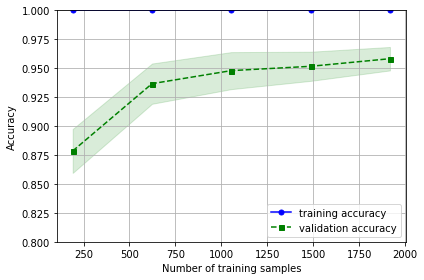

In [21]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr_xgb,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

По графику функции кривой обучения видно, что наша модель переобучена.

Теперь построим проверочную кривую обучения

In [22]:
pipe_lr_xgb = pipe_lr(
                XGBClassifier(
                        eval_metric='logloss',
                        verbosity = 0,
                    ))

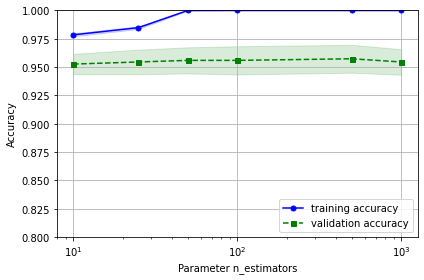

In [23]:
param_range = [10, 25, 50, 100, 500, 1000]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr_xgb, 
                X=X_train, 
                y=y_train, 
                param_name='clf__n_estimators', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter n_estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

Из графика кривой обучения можно увидеть, что достаточно 50 деревьев для предсказательной модели вместо 1000

In [24]:
pipe_lr_xgb = pipe_lr(
                XGBClassifier(
                        eval_metric='logloss',
                        verbosity = 0,
                        random_state=42
                    ))

Поищем лучшие параметры для XGBClassifier жадным алгоритмом поиска

In [25]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [26]:
param_grid = {'clf__max_depth': range(4,11),
              'clf__n_estimators':[40, 60, 80, 100, 200],
            #   'clf__max_features': [i for i in range(1, 18)], 
              'clf__min_samples_leaf': range(1,6)}

gs = GridSearchCV(estimator=pipe_lr_xgb, 
                  param_grid=param_grid, 
                  scoring=ftwo_scorer, 
                  cv=4,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8037806573406412
{'clf__max_depth': 4, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 80}


### Итоговая модель XGBoost

In [27]:
pipe_lr_xgb = pipe_lr(XGBClassifier(**gs.best_params_))
pipe_lr_xgb.fit(X_train, y_train)

y_pred = pipe_lr_xgb.predict(X_test)
fbeta_score(y_test, y_pred, beta=2)


0.7804232804232804

Прирост метрики Fbeta был незначительный. Посмотрим другие модели бустинга, такие как LightGBM, Catboost

## Модель LightGBM

In [28]:
import lightgbm as lgb

In [58]:
lgb_params = {
    'clf__n_estimators': [10, 50, 100],
    'clf__min_child_samples': range(1,5)
}
pipe_lr_lgbmr = pipe_lr(lgb.LGBMClassifier(random_state=42))
gs = GridSearchCV(estimator=pipe_lr_lgbmr, 
                  param_grid=lgb_params, 
                  scoring=ftwo_scorer, 
                  cv=4,
                  n_jobs=-1, 
                  verbose=True)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
0.7973625252139378
{'clf__min_child_samples': 2, 'clf__n_estimators': 50}


In [59]:
pipe_lr_lgbmr = pipe_lr(lgb.LGBMRegressor(**gs.best_params_))
pipe_lr_lgbmr.fit(X_train, y_train)

y_pred = pipe_lr_lgbmr.predict(X_test) > 0.5
fbeta_score(y_test, y_pred, beta=2)

0.7579787234042552

Предсказательная способность LightGBM оказалась ниже, чем у ранее исследованной модели XGBoost.

## Модель Catbost

In [62]:
from catboost import Pool, CatBoostClassifier

In [73]:
model = CatBoostClassifier(iterations=10,
                random_seed=42, depth=6, loss_function="Logloss",
                bootstrap_type="MVS", custom_metric='F1')

In [81]:
cb_params = {
    "depth": range(2,5),
    'learning_rate': np.arange(0.001,0.5,0.1),
    'l2_leaf_reg': range(1,5),
}
x_train_transform = preprocessor.fit_transform(X_train)
train_dataset = Pool(data=x_train_transform, label=y_train)
x_test_transform = Pool(data=preprocessor.transform(X_test))
cb_grid = model.grid_search(cb_params, cv=4, X=x_train_transform,
                y=y_train, verbose=True)
print (cb_grid["params"])

0:	learn: 0.6922643	test: 0.6922946	best: 0.6922946 (0)	total: 1.02ms	remaining: 101ms
1:	learn: 0.6914255	test: 0.6914448	best: 0.6914448 (1)	total: 2.18ms	remaining: 107ms
2:	learn: 0.6906934	test: 0.6907219	best: 0.6907219 (2)	total: 3.14ms	remaining: 102ms
3:	learn: 0.6899548	test: 0.6899926	best: 0.6899926 (3)	total: 4.13ms	remaining: 99.1ms
4:	learn: 0.6892063	test: 0.6892645	best: 0.6892645 (4)	total: 5.08ms	remaining: 96.6ms
5:	learn: 0.6884913	test: 0.6885410	best: 0.6885410 (5)	total: 6.21ms	remaining: 97.2ms
6:	learn: 0.6876493	test: 0.6877171	best: 0.6877171 (6)	total: 7.2ms	remaining: 95.6ms
7:	learn: 0.6869309	test: 0.6870070	best: 0.6870070 (7)	total: 8.45ms	remaining: 97.2ms
8:	learn: 0.6860383	test: 0.6861281	best: 0.6861281 (8)	total: 9.41ms	remaining: 95.2ms
9:	learn: 0.6854159	test: 0.6855178	best: 0.6855178 (9)	total: 10.4ms	remaining: 93.8ms
10:	learn: 0.6847983	test: 0.6849069	best: 0.6849069 (10)	total: 11.5ms	remaining: 92.7ms
11:	learn: 0.6840744	test: 0.68420

In [75]:
model = CatBoostClassifier(iterations=100,
        learning_rate=cb_grid["params"]["learning_rate"],
        depth=cb_grid["params"]["depth"],
        l2_leaf_reg=cb_grid["params"]["l2_leaf_reg"],
        random_seed=17, loss_function="Logloss",
        bootstrap_type="MVS", custom_metric="F1")

In [84]:
model.fit(train_dataset)
y_pred = model.predict(x_test_transform)

0:	learn: 0.5443341	total: 14.7ms	remaining: 1.45s
1:	learn: 0.4579693	total: 15.8ms	remaining: 772ms
2:	learn: 0.3998529	total: 16.9ms	remaining: 545ms
3:	learn: 0.3587864	total: 17.9ms	remaining: 431ms
4:	learn: 0.3253152	total: 19ms	remaining: 360ms
5:	learn: 0.2967864	total: 20ms	remaining: 313ms
6:	learn: 0.2793168	total: 20.9ms	remaining: 277ms
7:	learn: 0.2664063	total: 21.9ms	remaining: 251ms
8:	learn: 0.2478242	total: 22.8ms	remaining: 231ms
9:	learn: 0.2365270	total: 24ms	remaining: 216ms
10:	learn: 0.2265194	total: 25.2ms	remaining: 204ms
11:	learn: 0.2173512	total: 26.4ms	remaining: 193ms
12:	learn: 0.2115826	total: 27.7ms	remaining: 185ms
13:	learn: 0.2088614	total: 28.5ms	remaining: 175ms
14:	learn: 0.2031442	total: 29.4ms	remaining: 167ms
15:	learn: 0.1988663	total: 30.4ms	remaining: 159ms
16:	learn: 0.1959131	total: 31.3ms	remaining: 153ms
17:	learn: 0.1921264	total: 32.2ms	remaining: 147ms
18:	learn: 0.1881384	total: 33.3ms	remaining: 142ms
19:	learn: 0.1864650	total: 

In [88]:
fbeta_score(y_test, y_pred == 'True', beta = 2)

0.7824933687002652

Модель Catboost по точности предсказания сопоставима с XGBoost.

## Модель RandomForestClassifier

Попробуем улучшить предсказательную способность случайного леса путем подбора гиперпараметров по сетке. Возможно получить лучше результат, чем в предоставленном базавом варианте

In [89]:
# Для начала обучим алгоритм на самом простом, но надежном классификаторе
from sklearn.ensemble import RandomForestClassifier

# Инициализируем модель состоящую из 1000 решающих деревьев
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

tree_params = {
    'max_depth': range(3,10),
    'max_features': range(2,6),
    'n_estimators': range(20, 30),
    'min_samples_leaf': range(2,5)
}
tree_grid = GridSearchCV(rf, tree_params, cv=4, n_jobs=2,
            verbose=True, scoring=ftwo_scorer)
tree_grid.fit(X_train, y_train)

Fitting 4 folds for each of 840 candidates, totalling 3360 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=42),
             n_jobs=2,
             param_grid={'max_depth': range(3, 10), 'max_features': range(2, 6),
                         'min_samples_leaf': range(2, 5),
                         'n_estimators': range(20, 30)},
             scoring=make_scorer(fbeta_score, beta=2), verbose=True)

In [90]:
print (tree_grid.best_params_)

{'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 27}


In [91]:
rf = RandomForestClassifier(random_state=42,
        min_samples_leaf=tree_grid.best_params_['min_samples_leaf'],
        max_features=tree_grid.best_params_['max_features'],
        max_depth=tree_grid.best_params_['max_depth'],
        n_estimators=tree_grid.best_params_['n_estimators'])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [92]:
fbeta_score(y_test, y_pred, beta=2)

0.7392473118279571

Точность предсказания увеличилась относительно модели случайного леса без подбора гиперпараметров, однако данная модель все же более слабая, чем CatBoost и XGBoost.

## Модель нейронной сети (Keras)

Попробуем построить модель двухслойной нейронной сети.

In [109]:
from tensorflow import keras
from tensorflow.keras import layers

Подготовка данных

In [226]:
np_x_train = preprocessor.fit_transform(X_train)
np_y_train = y_train.to_numpy().astype("float32")

np_x_test = preprocessor.transform(X_test)
np_y_test = y_train.to_numpy().astype("float32")
np_y_train

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [242]:
def build_model():
    model = keras.Sequential([
        layers.Dense(22, activation="relu"),
        layers.Dense(22, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return model
    

In [229]:
x_val = np_x_train[:1600]
partial_x_train = np_x_train[1600:]
y_val = y_train[:1600]
partial_y_train = np_y_train[1600:]

In [243]:
history = build_model().fit(partial_x_train,
                        partial_y_train,
                        epochs=100,
                        batch_size=128,
                        validation_data=(x_val, y_val))

Epoch 1/100
5/5 [==============================] - 1s 35ms/step - loss: 0.6184 - accuracy: 0.7218 - val_loss: 0.5725 - val_accuracy: 0.7962
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.5638 - accuracy: 0.8139 - val_loss: 0.5351 - val_accuracy: 0.8375
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.5303 - accuracy: 0.8402 - val_loss: 0.5087 - val_accuracy: 0.8500
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 0.5055 - accuracy: 0.8477 - val_loss: 0.4876 - val_accuracy: 0.8544
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4849 - accuracy: 0.8477 - val_loss: 0.4717 - val_accuracy: 0.8556
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4687 - accuracy: 0.8496 - val_loss: 0.4568 - val_accuracy: 0.8550
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4541 - accuracy: 0.8515 - val_loss: 0.4433 - val_accuracy: 0.8556
Epoch 8/100
5/5 [=========

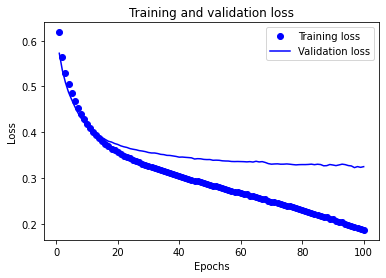

In [244]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

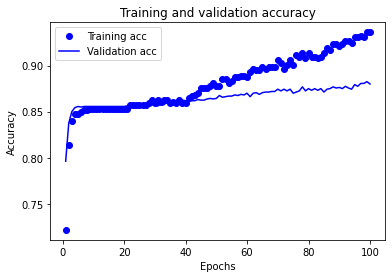

In [245]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [184]:
model = keras.Sequential([
    layers.Dense(22, activation="relu"),
    layers.Dense(64, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(np_x_train, y_train, epochs=100, batch_size=128, verbose=0)
results = model.evaluate(np_x_test, y_test)

17/17 [==============================] - 0s 918us/step - loss: 0.2656 - accuracy: 0.9195


In [247]:
y_pred = (model.predict(np_x_test) > 0.5).reshape(1, -1)[0]
fbeta_score(y_test.to_numpy(), y_pred, beta = 2)

0.6578947368421053

Нейросеть оказалось хуже, чем случайный лес и модели бустинга.

### Метод опорных векторов (SVM)

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipe_svm = pipe_with_transform(SVC(kernel='linear', probability=True, max_iter=5))
pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
fbeta_score(y_test, y_pred, beta = 2)

0.46042003231017764

### Логистическая регрессия

In [79]:
from sklearn.linear_model import LogisticRegression

In [100]:
pipe_logr = pipe_with_transform(LogisticRegression(max_iter=500))
pipe_logr.fit(X_train, y_train)
log_y_pred = pipe_logr.predict(X_test)
fbeta_score(y_test, log_y_pred, beta = 2)

0.25787965616045844

# <text style="color:red; font-size:120%">Ансамбль классификации</text>

Сформируем параллельный ансамбль из RandomForestClassifier, LightGBM, XGBoost, Catbost и нейросети.
Для формирования ансамбля возьмем лучшие параметры, подобранные ранее. Итоговое предсказание рассчитаем на основании весов моделей и вероятности предсказания класса (т.е. "мягким" голосованием).

Сгруппируем код для удобства

In [2]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

columns_to_del = ['State', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

train = train.drop(columns_to_del, axis = 1)

train['International plan'] = train['International plan'].replace({"Yes":1,"No":0}).astype('int64')
train['Voice mail plan'] = train['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')

test = test.drop(columns_to_del, axis = 1)

test['International plan'] = test['International plan'].replace({"Yes":1,"No":0}).astype('int64')
test['Voice mail plan'] = test['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')


In [3]:
from sklearn.model_selection import train_test_split

# Разделим train датасет на данные для обучения и валидации
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Churn'],axis=1),
                                                    train['Churn'], test_size=0.2, 
                                                    random_state=42)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

In [22]:
import warnings
warnings.filterwarnings("ignore")

## Предобратка данных (организация конвейров)

In [5]:
categorical_features = ['Area code', 'International plan', 'Voice mail plan']
numeric_features = X_train.columns.drop(categorical_features)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

def pipe_with_transform(clf):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    return Pipeline(
        steps=[("scl", preprocessor), ("clf", clf)]
    )

## Построение базовых моделей

### Случайный лес (RandomForestClassifier)

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
model_rf = RandomForestClassifier(
        min_samples_leaf=3,
        max_features=5,
        max_depth=9,
        n_estimators=27)
model_rf.fit(X_train, y_train)
rf_y_pred = model_rf.predict(X_test)
fbeta_score(y_test, rf_y_pred, beta = 2)

0.7277628032345014

### Модель градиентного бустинга XGBoost

In [19]:
from xgboost import XGBClassifier

In [34]:
pipe_xgb = pipe_with_transform(
    XGBClassifier(
        n_estimator=80,
        verbosity=0))
pipe_xgb.fit(X_train, y_train)

xgb_y_pred = pipe_xgb.predict(X_test)
fbeta_score(y_test, xgb_y_pred, beta=2)

0.7804232804232804

### Модель градиентного бустинга LightGBM

In [35]:
import lightgbm as lgb

In [36]:
pipe_lgbm = pipe_with_transform(lgb.LGBMRegressor())
pipe_lgbm.fit(X_train, y_train)

lgbm_y_pred = pipe_lgbm.predict(X_test) > 0.5
fbeta_score(y_test, lgbm_y_pred, beta=2)

0.7579787234042552

### Модель градиентного бустинга Catboost

In [37]:
from catboost import Pool, CatBoostClassifier

In [38]:
preprocessor_cb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
x_train_transform = preprocessor_cb.fit_transform(X_train)
train_dataset = Pool(data=x_train_transform, label=y_train)
x_test_transform = Pool(data=preprocessor_cb.transform(X_test))

model_catboost = CatBoostClassifier(
        iterations=100,
        learning_rate=1,
        depth=4,
        l2_leaf_reg=4,
        loss_function="Logloss",
        bootstrap_type="MVS",
        custom_metric="F1"
        )

model_catboost.fit(train_dataset, verbose=0)
catboost_y_pred = model_catboost.predict(x_test_transform) == 'True'
fbeta_score(y_test, catboost_y_pred, beta=2)

0.7611548556430447

## Модель двухслойной нейронной сети

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
np_x_train = preprocessor_nn.fit_transform(X_train)
np_y_train = y_train.to_numpy().astype("float32")

np_x_test = preprocessor_nn.transform(X_test)
np_y_test = y_train.to_numpy().astype("float32")

In [41]:
model_nn = keras.Sequential([
    layers.Dense(22, activation="relu"),
    layers.Dense(22, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])
model_nn.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_nn.fit(np_x_train, y_train, epochs=100, batch_size=128, verbose=0)
results = model_nn.evaluate(np_x_test, y_test)
nn_y_pred = (model_nn.predict(np_x_test) > 0.5).reshape(1, -1)[0]
fbeta_score(y_test.to_numpy(), nn_y_pred, beta = 2)

17/17 [==============================] - 0s 1ms/step - loss: 0.2522 - accuracy: 0.9213


0.6692913385826772

## Расчет предсказаний

Расчет итогово голосования будет происходить по "мягкой" схеме

In [42]:
target_test_rf_proba = pd.DataFrame(model_rf.predict_proba(X_test))
target_test_xgb_proba = pd.DataFrame(pipe_xgb.predict_proba(X_test))
target_test_lgb_proba = 1 - pd.DataFrame(pipe_lgbm.predict(X_test))
target_test_lgb_proba[1] = 1 - target_test_lgb_proba[0]
target_test_cb_proba = pd.DataFrame(
    model_catboost.predict_proba(
        Pool(data=preprocessor_cb.transform(X_test))
        ))
target_test_nn_proba = 1 - pd.DataFrame(
    model_nn.predict(
        preprocessor_nn.transform(X_test)
        ))
target_test_nn_proba[1] = 1 - target_test_nn_proba[0]

In [43]:
# Функция необходима для выбора класса при "мягком" голосования
def vote_class (x):
    a = np.argmax(x.values)
    return a

In [44]:
target_test_proba = target_test_rf_proba.copy()
for i in range(0, 2):
    target_test_proba[i] = target_test_rf_proba[i]
    target_test_proba[i] += target_test_xgb_proba[i]
    target_test_proba[i] += target_test_lgb_proba[i]
    target_test_proba[i] += target_test_cb_proba[i]
    target_test_proba[i] += target_test_nn_proba[i]
target_test_proba["target"] = target_test_proba.apply(vote_class, axis=1)

In [45]:
target_test_proba.head()

,0,1,target
0,0.426870,4.573130,1
1,4.856603,0.143397,0
2,4.911709,0.088291,0
3,0.188786,4.811214,1
4,0.151902,4.848098,1


In [46]:
fbeta_score(y_test, target_test_proba['target'], beta = 2)

0.7936507936507936

Поищим лучшие веса для вероятностей

In [62]:
from itertools import product
from tqdm import tqdm

In [82]:
arr_search_weight = []
for p in product(range(0, 105, 20), repeat=5):
    arr_search_weight.append(p)
arr_search_weight = np.array(arr_search_weight) / 10
arr_search_weight.shape

(7776, 5)

In [83]:
best_weight_comb = [0.5, arr_search_weight[1]]
for comb in tqdm(arr_search_weight):
    target_test_proba = target_test_rf_proba.copy()
    for i in range(0, 2):
        target_test_proba[i] = comb[0]*target_test_rf_proba[i]
        target_test_proba[i] += comb[1]*target_test_xgb_proba[i]
        target_test_proba[i] += comb[2]*target_test_lgb_proba[i]
        target_test_proba[i] += comb[3]*target_test_cb_proba[i]
        target_test_proba[i] += comb[4]*target_test_nn_proba[i]
    target_test_proba["target"] = target_test_proba.apply(vote_class, axis=1)
    fbeta = fbeta_score(y_test, target_test_proba['target'], beta = 2)
    if best_weight_comb[0] < fbeta:
        best_weight_comb[0] = fbeta
        best_weight_comb[1] = comb
print(best_weight_comb)

100%|██████████| 7776/7776 [01:16<00:00, 102.02it/s]

[0.8072916666666665, array([ 0.,  0., 10., 10.,  2.])]


Лучший набор весов для моделей "мягкого" голосования.

In [102]:
best_weight_comb = [0.8072916666666665, np.array([ 0.,  0., 10., 10.,  2.])]

Вывод:
Случайный лес и XGBoost отбрасываются из ансамбля.
Итоговый вариант ансамбля будет состоять из 3 моделей:
1. LightGBM;
2. Catboost;
3. Нейросеть.

Дообучим их на всем объеме данных и сделаем итоговое предсказание.

# Подготовка предсказания

In [111]:
X_train = train.drop(columns='Churn')
y_train = train['Churn']
X_test = test

In [112]:
pipe_lgbm = pipe_with_transform(lgb.LGBMRegressor())
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('scl',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Account length', 'Number vmail messages', 'Total day calls',
       'Total day charge', 'Total eve calls', 'Total eve charge',
       'Total night calls', 'Total night charge', 'Total intl calls',
       'Total intl charge', 'Customer service calls'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Area code',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('clf', LGBMRegressor())])

In [116]:
x_train_transform = preprocessor_cb.fit_transform(X_train)
train_dataset = Pool(data=x_train_transform, label=y_train)

model_catboost = CatBoostClassifier(
        iterations=100,
        learning_rate=1,
        depth=4,
        l2_leaf_reg=4,
        loss_function="Logloss",
        bootstrap_type="MVS",
        custom_metric="F1"
        )

model_catboost.fit(train_dataset, verbose=0)
catboost_y_pred = model_catboost.predict(x_test_transform) == 'True'

In [118]:
preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
np_x_train = preprocessor_nn.fit_transform(X_train)
np_y_train = y_train.to_numpy().astype("float32")

model_nn = keras.Sequential([
    layers.Dense(22, activation="relu"),
    layers.Dense(22, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])
model_nn.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_nn.fit(np_x_train, y_train, epochs=100, batch_size=128, verbose=0)

In [119]:
target_test_lgb_proba = 1 - pd.DataFrame(pipe_lgbm.predict(X_test))
target_test_lgb_proba[1] = 1 - target_test_lgb_proba[0]
target_test_cb_proba = pd.DataFrame(
    model_catboost.predict_proba(
        Pool(data=preprocessor_cb.transform(X_test))
        ))
target_test_nn_proba = 1 - pd.DataFrame(
    model_nn.predict(
        preprocessor_nn.transform(X_test)
        ))
target_test_nn_proba[1] = 1 - target_test_nn_proba[0]

In [125]:
target_test_proba = best_weight_comb[1][2]*target_test_lgb_proba
for i in range(0, 2):
    target_test_proba[i] += best_weight_comb[1][3]*target_test_cb_proba[i]
    target_test_proba[i] += best_weight_comb[1][4]*target_test_nn_proba[i]
target_test_proba["target"] = target_test_proba.apply(vote_class, axis=1)

<text style="color:green;font-size: 250%">Итоговое предсказание ID	5759214</text>

In [132]:
target_test_proba["target"].astype('bool').to_csv('submit_ans.csv')